In [2]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
from response import response, response_legacy

---------------
* We need two parameters for the response function which is a fitting function of response of each channel.
* First parameter: x is the timing information in the waveform.
* Second parameter: param = [2.0, 1.5, 0.8, 0.6, 0.4, 0.2, 0.1].
  1. The First element defines a shifting value that we might use for the time information
  2. The second element defines the amplitude of the fitted waveform.
  3. The third element defines the peaking time of the waveform, which is the time needed to reach the peak of the waveform.
  4. 4th, 5th, 6th, and 7th are the parameters k3[i], k4[i], k5[i], and k6[i] of the fit. A classification of the waveforms will be based on the values of these parameters.

In [3]:
# Read real data and extract the ranges of the fit parameters
real_data_df = pd.read_csv('data/two_data.csv')
real_data_df

,#Ch. #,t,E(t),A_0,E(A_0),t_p,E(t_p),k3,E(k3),k4,E(k4),k5,E(k5),k6,E(k6),Chi2/DOF,Overshoot,Undershoot,Ideal,Singularity
0,0,5.168380,0.016480,63551.21586,457.255779,2.005194,0.011204,0.084885,0.016731,0.083182,0.007405,0.084845,0.017068,0.083149,0.007296,8.314216,True,False,False,False
1,1,5.125260,0.016402,64050.18259,453.216645,1.982492,0.010483,0.076184,0.002083,0.082611,0.002288,-0.168491,0.000001,-0.168490,0.000001,6.624724,False,True,False,False
2,2,5.126215,0.016700,63789.33173,450.512634,2.051578,0.011507,0.128736,0.002802,0.144325,0.002418,0.128579,0.002794,0.115445,0.001615,3.475155,False,True,False,False
3,3,5.126688,0.017194,63692.52284,455.249167,1.971281,0.011576,0.093918,0.037538,0.136646,0.003721,0.093917,0.037537,0.058203,0.001226,5.964010,False,True,False,False
4,4,5.055860,0.022534,74734.46744,16428.503940,2.233869,0.024320,0.972904,0.066550,1.267541,0.075325,0.026909,0.004198,0.025164,0.004034,2.673853,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,10235,5.101184,0.015606,76216.71273,493.706403,2.068169,0.010576,0.052520,0.000635,0.059161,0.000559,0.050288,0.000611,0.044591,0.000453,3.960262,False,True,False,False
20476,10236,5.092284,0.016012,74529.32006,485.433216,2.151517,0.011246,-0.122913,0.000001,0.046218,0.000470,0.043957,0.000450,-0.122915,0.000001,3.615962,False,True,False,False
20477,10237,5.109026,0.015401,75761.00213,489.494351,2.060611,0.010334,0.014339,0.000353,0.029083,0.000344,0.021926,0.000426,0.010108,0.000264,3.600842,False,True,False,False
20478,10238,5.040453,0.016358,75351.59727,483.226248,2.216201,0.011431,0.017719,0.001247,0.044592,0.001441,0.017691,0.001243,0.006902,0.001319,4.925204,False,True,False,False


In [4]:
# classify the parameter ranges
k3_ranges = {'below 2': real_data_df[real_data_df[' k3 ']<2][' k3 '], 'above 2': real_data_df[real_data_df[' k3 ']>=2][' k3 ']}
k4_ranges = {'below 2': real_data_df[real_data_df[' k4 ']<2][' k4 '], 'above 2': real_data_df[real_data_df[' k4 ']>=2][' k4 ']}
k5_ranges = {'below 2': real_data_df[real_data_df[' k5 ']<2][' k5 '], 'above 2': real_data_df[real_data_df[' k5 ']>=2][' k5 ']}
k6_ranges = {'below 2': real_data_df[real_data_df[' k6 ']<2][' k6 '], 'above 2': real_data_df[real_data_df[' k6 ']>=2][' k6 ']}

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11052/3315460537.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax[i].step(bins[:-1], counts, where='post', label=f'{key}\n mean = {mean}, $\sigma$ = {std}\n median = {median}')


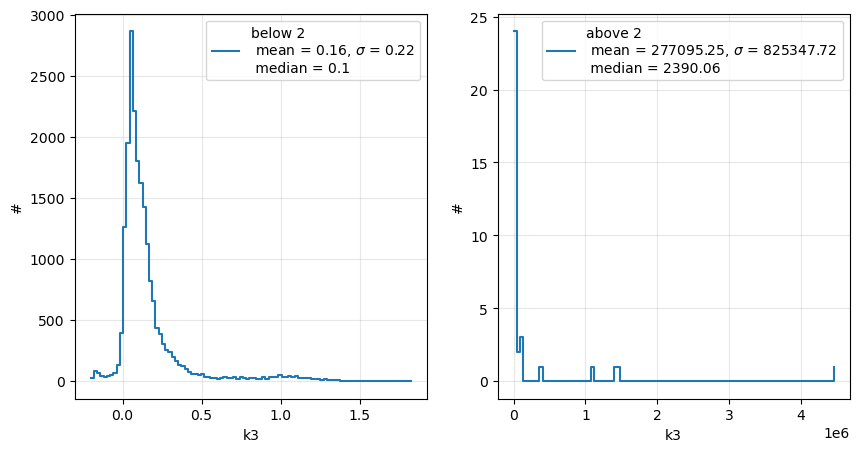

In [5]:
fig, ax = plt.subplots(1,2,figsize=(5*2, 5))
i = 0
for key, item in k3_ranges.items():
    # Create histogram using numpy
    counts, bins = np.histogram(item, bins=100)  # 50 bins
    mean, std = np.round(np.mean(item),2), np.round(np.std(item),2)
    median = np.round(np.median(item),2)
    # 'steps-post' means the step happens after the point
    ax[i].step(bins[:-1], counts, where='post', label=f'{key}\n mean = {mean}, $\sigma$ = {std}\n median = {median}')
    ax[i].set_xlabel('k3')
    ax[i].set_ylabel('#')
    ax[i].grid(True, alpha=0.3)
    ax[i].legend()
    i+=1

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11052/3484747321.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax[i].step(bins[:-1], counts, where='post', label=f'{key}\n mean = {mean}, $\sigma$ = {std}\n median = {median}')


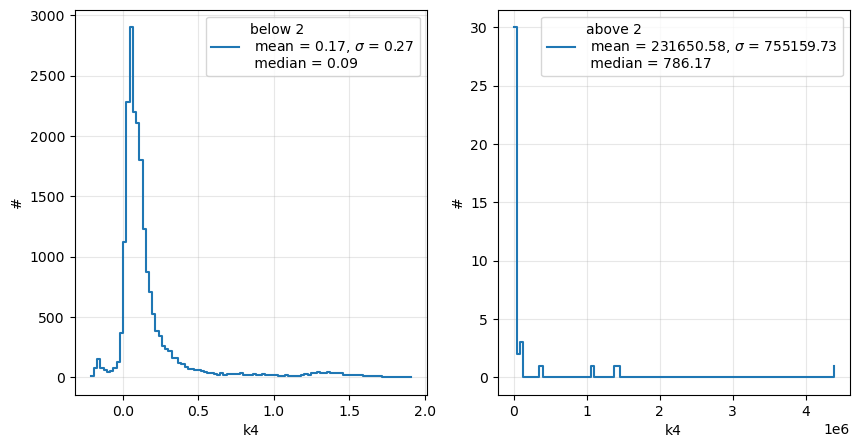

In [6]:
fig, ax = plt.subplots(1,2,figsize=(5*2, 5))
i = 0
for key, item in k4_ranges.items():
    # Create histogram using numpy
    counts, bins = np.histogram(item, bins=100)  # 50 bins
    mean, std = np.round(np.mean(item),2), np.round(np.std(item),2)
    median = np.round(np.median(item),2)
    # 'steps-post' means the step happens after the point
    ax[i].step(bins[:-1], counts, where='post', label=f'{key}\n mean = {mean}, $\sigma$ = {std}\n median = {median}')
    ax[i].set_xlabel('k4')
    ax[i].set_ylabel('#')
    ax[i].grid(True, alpha=0.3)
    ax[i].legend()
    i+=1

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11052/2936338216.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax[i].step(bins[:-1], counts, where='post', label=f'{key}\n mean = {mean}, $\sigma$ = {std}\n median = {median}')


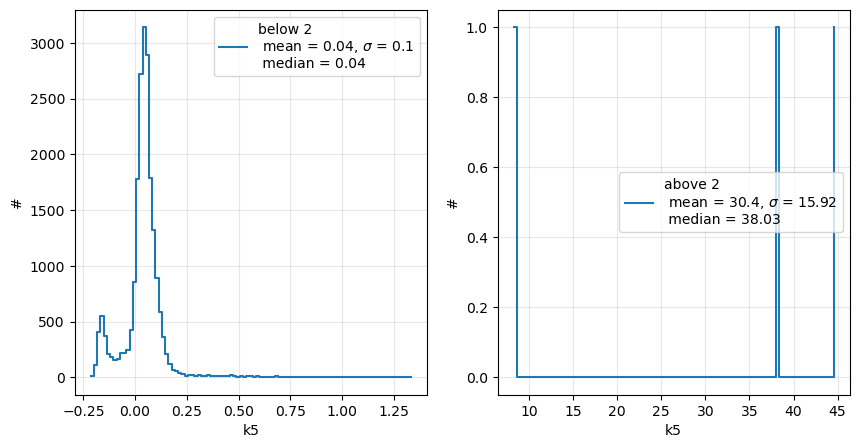

In [7]:
fig, ax = plt.subplots(1,2,figsize=(5*2, 5))
i = 0
for key, item in k5_ranges.items():
    # Create histogram using numpy
    counts, bins = np.histogram(item, bins=100)  # 50 bins
    mean, std = np.round(np.mean(item),2), np.round(np.std(item),2)
    median = np.round(np.median(item),2)
    # 'steps-post' means the step happens after the point
    ax[i].step(bins[:-1], counts, where='post', label=f'{key}\n mean = {mean}, $\sigma$ = {std}\n median = {median}')
    ax[i].set_xlabel('k5')
    ax[i].set_ylabel('#')
    ax[i].grid(True, alpha=0.3)
    ax[i].legend()
    i+=1

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11052/1896203076.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax[i].step(bins[:-1], counts, where='post', label=f'{key}\n mean = {mean}, $\sigma$ = {std}\n median = {median}')


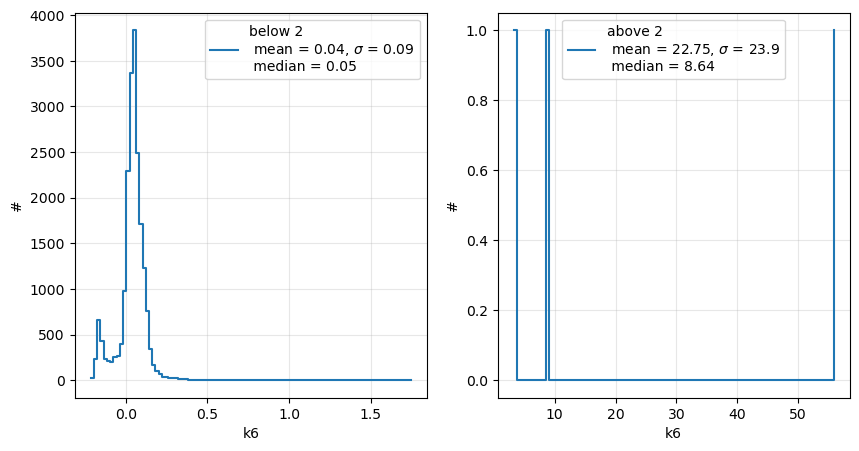

In [8]:
fig, ax = plt.subplots(1,2,figsize=(5*2, 5))
i = 0
for key, item in k6_ranges.items():
    # Create histogram using numpy
    counts, bins = np.histogram(item, bins=100)  # 50 bins
    mean, std = np.round(np.mean(item),2), np.round(np.std(item),2)
    median = np.round(np.median(item),2)
    # 'steps-post' means the step happens after the point
    ax[i].step(bins[:-1], counts, where='post', label=f'{key}\n mean = {mean}, $\sigma$ = {std}\n median = {median}')
    ax[i].set_xlabel('k6')
    ax[i].set_ylabel('#')
    ax[i].grid(True, alpha=0.3)
    ax[i].legend()
    i+=1

In [9]:
real_data_df[real_data_df[' k3 ']>=2].head()

,#Ch. #,t,E(t),A_0,E(A_0),t_p,E(t_p),k3,E(k3),k4,E(k4),k5,E(k5),k6,E(k6),Chi2/DOF,Overshoot,Undershoot,Ideal,Singularity
2093,2093,5.133599,0.016860,61422.40765,4638.148313,2.027794,0.011285,3642.328775,282.164823,3585.244574,271.508051,-0.172863,4.433444e-07,-0.172862,4.445782e-07,4.356855,True,False,False,False
2503,2503,5.127520,0.017202,61198.52184,4150.948100,2.005672,0.011257,85344.073070,5908.045769,84007.945070,5701.922798,-0.181498,2.555469e-07,-0.181498,2.541602e-07,5.297930,True,False,False,False
2586,2586,5.138722,0.016670,64350.43843,772.515628,1.992092,0.011172,2.735816,0.151786,2.810960,0.172445,-0.170611,6.125508e-03,-0.170612,6.125387e-03,4.851358,False,True,False,False
3763,3763,5.124737,0.016810,62311.60143,4879.375953,1.997927,0.011088,1809.917646,145.691241,1782.339111,139.520950,-0.141305,7.536271e-07,-0.141306,7.525358e-07,5.696274,True,False,False,False
4035,4035,5.136571,0.016725,61528.72325,4867.063023,2.016593,0.011190,2970.207268,241.676213,2923.984346,232.016132,-0.160193,1.033585e-06,-0.160194,1.032946e-06,4.450205,True,False,False,False


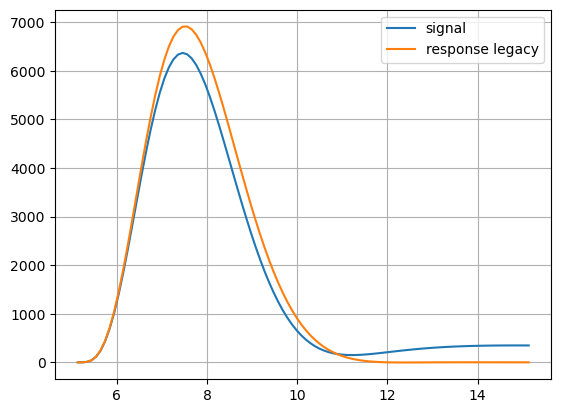

'\n1. Ideal: k3[i]=k4[i] and k5[i]=k6[i], or k3[i]=k6[i] and k4[i]=k5[i]\n2. Singularity: k4[i]=k6[i]\n3. Overshoot: (k3[i]>k4[i] and k5[i]>=k6[i]), or (k5[i]>k6[i] and k3[i]>=k4[i]), or (k4[i]<k5[i] and (k3[i]>=k6[i]), or (k3[i]>k5[i])  [It seems these conditions are not enough]\n4. Undershoot: Otherwise\n'

In [17]:
# A = 1.5
A = np.mean(real_data_df[' A_0 '])
t0 = -0.1
t0 = real_data_df[' t '].iloc[2093]
# tp = 2.0
tp = np.mean(real_data_df[' t_p '])
n_samples = np.power(10, 6)
np.random.seed(30)
k3_all = np.random.uniform(0, 1, n_samples)
k4_all = np.random.uniform(0, 1, n_samples)
k5_all = np.random.uniform(0, 1, n_samples)
k6_all = np.random.uniform(0, 1, n_samples)

np.random.shuffle(k3_all)
np.random.shuffle(k4_all)
np.random.shuffle(k5_all)
np.random.shuffle(k6_all)

# x = [1.0,2.0,3.0,4.0,5.0]  # x is a list with one element
x = np.linspace(t0, t0+10, np.power(10, 2))
par = [t0, A, tp, 0.2, 0.1, 0.3, 0.5]  # par is a list of 7 elements as per the function
par_ideal = [t0, A, tp, 0.2,0.2, 0.4,0.4]
R = response(x=x, par=par)
R_ideal = response(x=x, par=par_ideal)
R_response_legacy = response_legacy(x=x, par=[t0, A, tp])

plt.figure()
plt.plot(x, R, label='signal')
# plt.plot(x, R_ideal, label='Ideal response')
plt.plot(x, R_response_legacy, label='response legacy')
plt.legend()
plt.grid(True)
plt.show()
'''
1. Ideal: k3[i]=k4[i] and k5[i]=k6[i], or k3[i]=k6[i] and k4[i]=k5[i]
2. Singularity: k4[i]=k6[i]
3. Overshoot: (k3[i]>k4[i] and k5[i]>=k6[i]), or (k5[i]>k6[i] and k3[i]>=k4[i]), or (k4[i]<k5[i] and (k3[i]>=k6[i]), or (k3[i]>k5[i])  [It seems these conditions are not enough]
4. Undershoot: Otherwise
'''

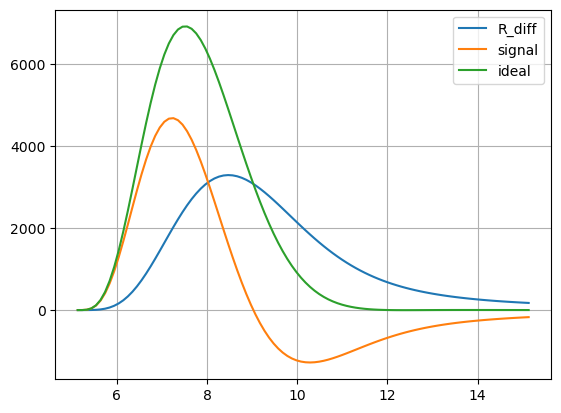

In [20]:
R_diff = R_response_legacy-R
plt.figure()
plt.plot(x, R_diff, label='R_diff')
plt.plot(x, R, label='signal')
plt.plot(x, R_response_legacy, label='ideal')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
simdata_df = pd.read_csv('simulation_data.csv')
simdata_df.head()

,k3,k4,k5,k6,class
0,-0.452744,-0.582004,-0.582004,-0.452744,Overshoot
1,-0.250516,0.686300,-0.039354,0.135301,Undershoot
2,-0.399387,0.708746,0.498897,0.708746,Singularity
3,0.149704,0.149704,0.032483,0.032483,Ideal
4,-0.033138,0.504122,0.040915,0.220249,Undershoot


In [89]:
from scipy import integrate
A = 1.5
t0 = -0.1
tp = 2.0
x = np.linspace(t0, t0+10, np.power(10, 2))

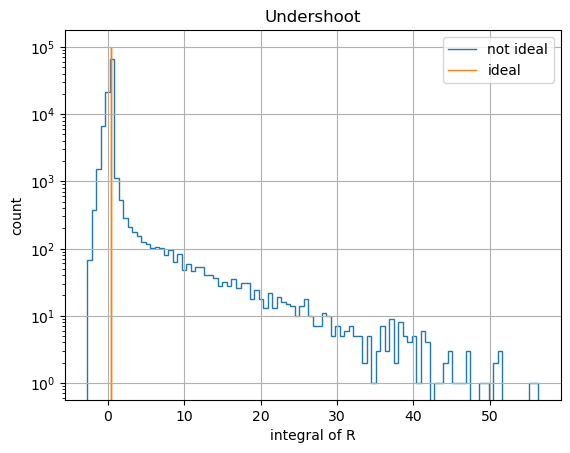

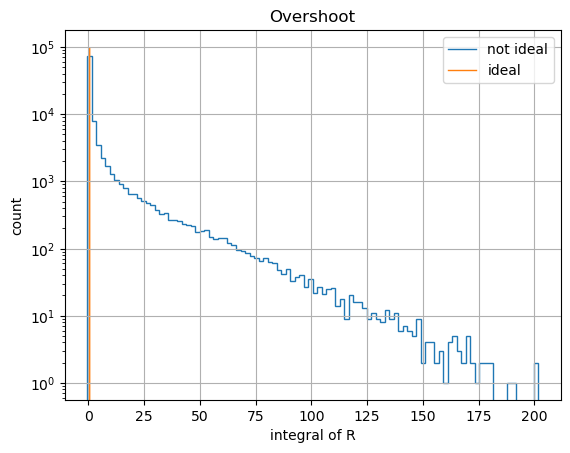

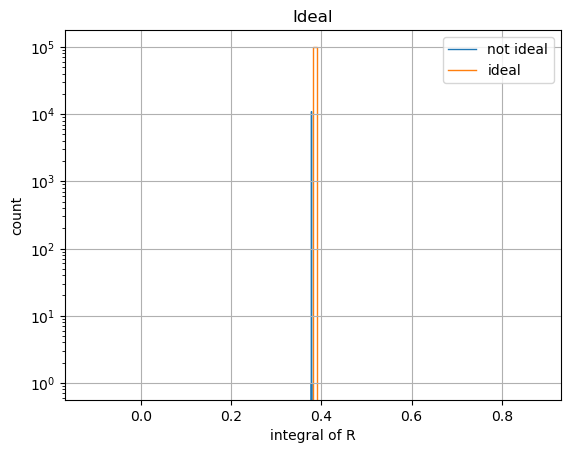

/media/rado/RADO/WORKSPACE/CE_Project/response.py:28: RuntimeWarning: overflow encountered in exp
  value = A*((-(k3*k4) + pow(k4,2) + k3*k5 - k4*k5)/(np.exp(k4*t)*(k4 - k6)*(k4 - p0)*(pow(k4,2) + pow(pi1,2) - 2*k4*pr1 + pow(pr1,2))*(pow(k4,2) + pow(pi2,2) - 2*k4*pr2 + pow(pr2,2))) +
/media/rado/RADO/WORKSPACE/CE_Project/response.py:29: RuntimeWarning: overflow encountered in exp
  (-(k3*k5) + k3*k6 + k5*k6 - pow(k6,2))/(np.exp(k6*t)*(k4 - k6)*(k6 - p0)*(pow(k6,2) + pow(pi1,2) - 2*k6*pr1 + pow(pr1,2))*(pow(k6,2) + pow(pi2,2) - 2*k6*pr2 + pow(pr2,2))) +
/media/rado/RADO/WORKSPACE/CE_Project/response.py:28: RuntimeWarning: overflow encountered in multiply
  value = A*((-(k3*k4) + pow(k4,2) + k3*k5 - k4*k5)/(np.exp(k4*t)*(k4 - k6)*(k4 - p0)*(pow(k4,2) + pow(pi1,2) - 2*k4*pr1 + pow(pr1,2))*(pow(k4,2) + pow(pi2,2) - 2*k4*pr2 + pow(pr2,2))) +
/media/rado/RADO/WORKSPACE/CE_Project/response.py:29: RuntimeWarning: overflow encountered in multiply
  (-(k3*k5) + k3*k6 + k5*k6 - pow(k6,2))/(np.exp

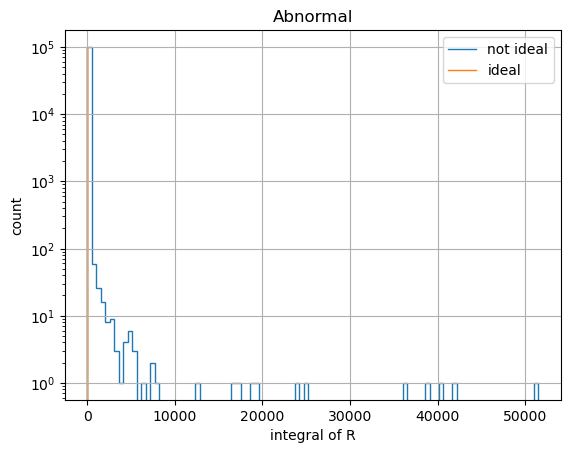

In [136]:
classes = ['Undershoot', 'Overshoot', 'Ideal', 'Abnormal']
for CLASS in classes:
    overshoot_df = simdata_df[simdata_df['class']==CLASS].iloc[:100000]
    overshoot_df_copy = overshoot_df.copy().reset_index().drop('index', axis=1)
    integral_R_all = []
    integral_R_ideal_all = []
    integral_R_diff = []
    for i in range(len(overshoot_df_copy)):
        lineParam = overshoot_df_copy.iloc[i]
        par = [t0, A, tp, lineParam['k3'], lineParam['k4'], lineParam['k5'], lineParam['k6']]
        R = response(x=x, par=par)
        par_ideal = [par[0], par[1], par[2]]
        R_ideal = response_legacy(x=x, par=par_ideal)
        # plt.figure()
        # plt.plot(x, R)
        # plt.plot(x, R_ideal)
        # plt.show()
        # break
        integral_R = integrate.simpson(y=R, x=x)
        integral_R_ideal = integrate.simpson(y=R_ideal, x=x)
        # print(integral_R, integral_R_ideal)
        integral_R_all.append(integral_R)
        integral_R_ideal_all.append(integral_R_ideal)
    integral_R_diff = np.array(integral_R_ideal_all) - np.array(integral_R_all)
    overshoot_df_copy['integral_R'] = integral_R_all
    overshoot_df_copy['integral_ideal'] = integral_R_ideal_all
    overshoot_df_copy['diff_integral'] = integral_R_diff
    # print(overshoot_df_copy.head())
    # break
    plt.figure()
    counts_R, bins_R = np.histogram(integral_R_all, bins=100)
    counts_ideal, bins_ideal = np.histogram(integral_R_ideal_all, bins=100)
    counts_diff, bins_diff = np.histogram(integral_R_diff, bins=100)
    # plt.hist(integral_R_ideal_all, alpha=0.8, label='ideal')
    # plt.hist(integral_R_all, alpha=0.2, label='not ideal')
    plt.stairs(counts_R, bins_R, label='not ideal')
    plt.stairs(counts_ideal, bins_ideal, label='ideal')
    # plt.stairs(counts_diff, bins_diff, label='difference : R_ideal - R')
    plt.xlabel('integral of R')
    plt.ylabel('count')
    plt.yscale('log')
    plt.title(CLASS)
    plt.legend()
    plt.grid(True)
    plt.show()



In [97]:
data_df = pd.read_csv('data/two_data.csv')
data_df.head()

,#Ch. #,t,E(t),A_0,E(A_0),t_p,E(t_p),k3,E(k3),k4,E(k4),k5,E(k5),k6,E(k6),Chi2/DOF,Overshoot,Undershoot,Ideal,Singularity
0,0,5.168380,0.016480,63551.21586,457.255779,2.005194,0.011204,0.084885,0.016731,0.083182,0.007405,0.084845,0.017068,0.083149,0.007296,8.314216,True,False,False,False
1,1,5.125260,0.016402,64050.18259,453.216645,1.982492,0.010483,0.076184,0.002083,0.082611,0.002288,-0.168491,0.000001,-0.168490,0.000001,6.624724,False,True,False,False
2,2,5.126215,0.016700,63789.33173,450.512634,2.051578,0.011507,0.128736,0.002802,0.144325,0.002418,0.128579,0.002794,0.115445,0.001615,3.475155,False,True,False,False
3,3,5.126688,0.017194,63692.52284,455.249167,1.971281,0.011576,0.093918,0.037538,0.136646,0.003721,0.093917,0.037537,0.058203,0.001226,5.964010,False,True,False,False
4,4,5.055860,0.022534,74734.46744,16428.503940,2.233869,0.024320,0.972904,0.066550,1.267541,0.075325,0.026909,0.004198,0.025164,0.004034,2.673853,False,True,False,False


In [131]:
R_int_all = []
R_ideal_all = []
for i in range(len(data_df)):
    lineParam = data_df.iloc[i]
    par = [lineParam[' t '], lineParam[' A_0 '], lineParam[' t_p '], lineParam[' k3 '], lineParam[' k4 '], lineParam[' k5 '], lineParam[' k6 ']]
    R = response(x=x, par=par)
    R_ideal = response_legacy(x=x, par=par)
    tmp_int_R = integrate.simpson(y=R, x=x)
    tmp_int_ideal = integrate.simpson(y=R_ideal, x=x)
    if np.abs(tmp_int_R) != np.inf:
        R_int_all.append(tmp_int_R)
    # if np.abs(tmp_int_ideal) != np.inf:
        R_ideal_all.append(tmp_int_ideal)
counts_R, bins_R = np.histogram(R_int_all, bins=100)
counts_R_ideal, bins_R_ideal = np.histogram(R_ideal_all, bins=100)

/media/rado/RADO/WORKSPACE/CE_Project/response.py:28: RuntimeWarning: overflow encountered in exp
  value = A*((-(k3*k4) + pow(k4,2) + k3*k5 - k4*k5)/(np.exp(k4*t)*(k4 - k6)*(k4 - p0)*(pow(k4,2) + pow(pi1,2) - 2*k4*pr1 + pow(pr1,2))*(pow(k4,2) + pow(pi2,2) - 2*k4*pr2 + pow(pr2,2))) +
/media/rado/RADO/WORKSPACE/CE_Project/response.py:28: RuntimeWarning: divide by zero encountered in divide
  value = A*((-(k3*k4) + pow(k4,2) + k3*k5 - k4*k5)/(np.exp(k4*t)*(k4 - k6)*(k4 - p0)*(pow(k4,2) + pow(pi1,2) - 2*k4*pr1 + pow(pr1,2))*(pow(k4,2) + pow(pi2,2) - 2*k4*pr2 + pow(pr2,2))) +
/media/rado/RADO/WORKSPACE/CE_Project/response.py:28: RuntimeWarning: overflow encountered in multiply
  value = A*((-(k3*k4) + pow(k4,2) + k3*k5 - k4*k5)/(np.exp(k4*t)*(k4 - k6)*(k4 - p0)*(pow(k4,2) + pow(pi1,2) - 2*k4*pr1 + pow(pr1,2))*(pow(k4,2) + pow(pi2,2) - 2*k4*pr2 + pow(pr2,2))) +
/media/rado/RADO/WORKSPACE/CE_Project/response.py:28: RuntimeWarning: overflow encountered in divide
  value = A*((-(k3*k4) + pow(k

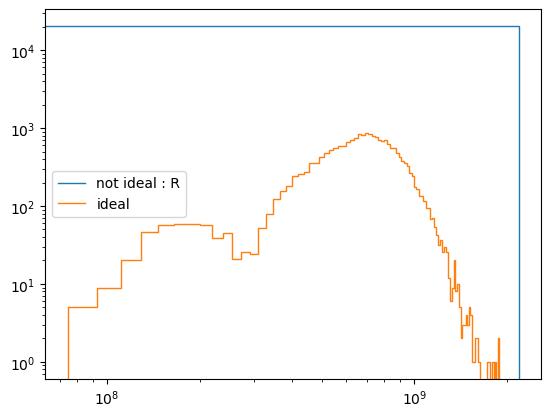

In [135]:
diff = np.array(R_ideal_all) - np.array(R_int_all)
count_diff, bins_diff = np.histogram(diff, bins=100)
plt.figure()
plt.stairs(counts_R, bins_R, label='not ideal : R')
plt.stairs(counts_R_ideal, bins_R_ideal, label='ideal')
# plt.stairs(count_diff, bins_diff, label='difference : integral_R_ideal - integral_R')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

---------------------------------

In [ ]:
def classify(k3,k4,k5,k6):
    classes = []
    for i in range(len(k3)):
        if (k3[i]>2) | (k4[i]>2) | (k5[i]>2) | (k6[i]>2):
            classes.append('Abnormal')
        elif (k3[i]==k4[i]) and (k5[i]==k6[i]):
            classes.append('Ideal')
        elif k4[i]==k6[i]:
            classes.append('Singularity')
        elif (k3[i]>k4[i] and k5[i]>=k6[i]) | (k5[i]>k6[i] and k3[i]>=k4[i]) | ((k4[i]<k5[i]) and (k3[i]>=k6[i])) | (k3[i]>k5[i]):
            classes.append('Overshoot')
        else:
             classes.append('Undershoot')
    return classes

In [ ]:
## Undershoot/Overshoot data
n_samples = 3*np.power(10, 5)
k3_all_uo = np.random.uniform(-0.5, 0.82, n_samples)
k4_all_uo = np.random.uniform(-0.64, 0.98, n_samples)
k5_all_uo = np.random.uniform(-0.26, 0.34, n_samples)
k6_all_uo = np.random.uniform(-0.23, 0.31, n_samples)

np.random.shuffle(k3_all_uo)
np.random.shuffle(k4_all_uo)
np.random.shuffle(k5_all_uo)
np.random.shuffle(k6_all_uo)

df = pd.DataFrame({'k3':k3_all_uo, 'k4':k4_all_uo, 'k5':k5_all_uo, 'k6': k6_all_uo})
df['class'] = classify(k3=df['k3'], k4=df['k4'], k5=df['k5'], k6=df['k6'])

In [ ]:
# Ideal / Singularity
n_samples = 3*np.power(10, 5)
k3_all_is = np.concatenate([np.linspace(-0.64, 0.98, n_samples), np.linspace(-0.5, 0.82, n_samples), np.random.uniform(-0.64, 0.98, n_samples), np.random.uniform(2, 1E6, n_samples)])
k4_all_is = np.concatenate([np.linspace(-0.64, 0.98, n_samples), np.linspace(-0.64, 0.98, n_samples), np.linspace(-0.64, 0.98, n_samples), np.random.uniform(2, 1E6, n_samples)])
k5_all_is = np.concatenate([np.linspace(-0.26, 0.34, n_samples), np.linspace(-0.64, 0.98, n_samples), np.random.uniform(-0.64, 0.98, n_samples), np.random.uniform(2, 1E6, n_samples)])
k6_all_is = np.concatenate([np.linspace(-0.26, 0.34, n_samples), np.linspace(-0.5, 0.82, n_samples), np.linspace(-0.64, 0.98, n_samples), np.random.uniform(2, 1E6, n_samples)])

# np.random.shuffle(k3_all_uo)
# np.random.shuffle(k4_all_uo)
# np.random.shuffle(k5_all_uo)
# np.random.shuffle(k6_all_uo)
dff = pd.DataFrame({'k3': k3_all_is, 'k4': k4_all_is, 'k5': k5_all_is, 'k6': k6_all_is})
dff['class'] = classify(k3=k3_all_is, k4=k4_all_is, k5=k5_all_is, k6=k6_all_is)

In [ ]:
df = pd.concat([df,dff], axis=0)

In [ ]:
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
shuffled_df

,k3,k4,k5,k6,class
0,-0.452744,-0.582004,-0.582004,-0.452744,Overshoot
1,-0.250516,0.686300,-0.039354,0.135301,Undershoot
2,-0.399387,0.708746,0.498897,0.708746,Singularity
3,0.149704,0.149704,0.032483,0.032483,Ideal
4,-0.033138,0.504122,0.040915,0.220249,Undershoot
...,...,...,...,...,...
1499995,0.259645,0.028643,0.233821,0.214161,Overshoot
1499996,456143.342435,89004.676071,79153.249457,920308.283299,Abnormal
1499997,0.807450,0.011104,0.081955,0.016689,Overshoot
1499998,-0.186917,-0.255762,-0.255762,-0.186917,Overshoot


In [ ]:
shuffled_df.to_csv('simulation_data.csv', index=False)

In [ ]:
d = {'k3': list(k3_all), 'k4': list(k4_all), 'k5': list(k5_all), 'k6': list(k6_all)}

In [ ]:
df = pd.DataFrame(d)

In [ ]:
df['class'] = classify(k3=df['k3'], k4=df['k4'], k5=df['k5'], k6=df['k6'])

In [ ]:
df

,k3,k4,k5,k6,class
0,0.408232,0.239955,0.153430,0.809399,Undershoot
1,0.802189,0.650490,0.849338,0.470296,Overshoot
2,0.391896,0.186367,0.072552,0.612594,Undershoot
3,0.030705,0.451055,0.797794,0.155960,Undershoot
4,0.555868,0.641828,0.739862,0.955336,Undershoot
...,...,...,...,...,...
999995,0.173754,0.109708,0.436013,0.357679,Overshoot
999996,0.999325,0.177129,0.563228,0.240546,Overshoot
999997,0.415428,0.403832,0.002440,0.976899,Undershoot
999998,0.201680,0.315231,0.161832,0.233920,Undershoot


In [ ]:
df.to_csv('simulation_data.csv', index=False)

In [ ]:
0.16-3*0.22, 0.16+3*0.22

(-0.5, 0.8200000000000001)

In [ ]:
0.17-3*0.27,0.17+3*0.27

(-0.64, 0.9800000000000001)

In [ ]:
0.04-3*0.1,0.04+3*0.1

(-0.26000000000000006, 0.34)

In [ ]:
0.04-3*0.09, 0.04+3*0.09

(-0.23, 0.31)